In [1]:
import scanpy as sc
import scib
import pandas as pd
import click

/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Impor

In [2]:
import os
# 替换为步骤1中获取的R_HOME路径
os.environ['R_HOME'] = "/share/home/lhlin/.conda/envs/scib/lib/R" 
import rpy2
import rpy2.rinterface as rinterface

## 选择方法并跑流程

In [3]:
integration_method = 'scANVI'

In [4]:
orig_data = {
    "harmonyCCA":'/share/home/lhlin/DATA/lung_cca_harmony_integration.h5ad', #1 python
    "harmony": '/share/home/lhlin/DATA/lung_cca_harmony_integration.h5ad', #2 python
    "scanorama": '/share/home/lhlin/DATA/lung_cca_harmony_integration.h5ad', #3 python
    "scANVI": '/share/home/lhlin/DATA/lung_cca_harmony_integration.h5ad', #4 python
    "LIGER": '/share/home/lhlin/DATA/lung_cca_harmony_integration.h5ad', #5 python
    "fastMNN": '/share/home/lhlin/workspace/1-EndoAtlas/results/fastMNN_integration.h5ad', #6
    "saturn":'/share/home/lhlin/workspace/1-EndoAtlas/results/saturn_integration.h5ad', #7 python
    "seuratCCA": '/share/home/lhlin/workspace/1-EndoAtlas/results/seuratCCA_integration.h5ad', #8
    "seuratRPCA": '/share/home/lhlin/workspace/1-EndoAtlas/results/seuratRPCA_integration.h5ad'#9
}

In [5]:
input_data = {
    "harmonyCCA":'/share/home/lhlin/DATA/lung_cca_harmony_integration.h5ad', #1
    "harmony": '/share/home/lhlin/workspace/1-EndoAtlas/results/harmony_integration.h5ad', #2
    "scanorama": '/share/home/lhlin/workspace/1-EndoAtlas/results/scanorama_integration.h5ad', #3
    "scANVI": '/share/home/lhlin/workspace/1-EndoAtlas/results/scANVI_integration.h5ad', #4
    "LIGER": '/share/home/lhlin/workspace/1-EndoAtlas/results/LIGER_integration.h5ad', #5
    "fastMNN": '/share/home/lhlin/workspace/1-EndoAtlas/results/fastMNN_integration.h5ad', #6
    "saturn":'/share/home/lhlin/workspace/1-EndoAtlas/results/saturn_integration.h5ad', #7
    "seuratCCA": '/share/home/lhlin/workspace/1-EndoAtlas/results/seuratCCA_integration.h5ad', #8
    "seuratRPCA": '/share/home/lhlin/workspace/1-EndoAtlas/results/seuratRPCA_integration.h5ad'#9
}

In [6]:
def run_scIB_metrics(
    input_h5ad,
    unintegrated_h5ad,
    out_integrated_metrics,
    out_integrated_basw,
    out_orig_metrics,
    out_orig_basw,
    out_h5ad,
    species_key,
    batch_key,
    cluster_key,
    integration_method):
    # dictionary for method properties
    embedding_keys = {
        "harmony": "X_pca_harmony",
        "scanorama": "X_scanorama",
        "scVI": "X_scVI",
        "scANVI": "X_scANVI",
        "LIGER": "X_inmf",
        "rligerUINMF": "X_inmf",
        "fastMNN": "X_mnn",
        "harmonyCCA":"X_cca_harmony",
        "saturn":"X_saturn"
    }
    use_embeddings = {
        "harmony": True,
        "scanorama": True,
        "scVI": True,
        "scANVI": True,
        "LIGER": True,
        "rligerUINMF": True,
        "fastMNN": True,
        "harmonyCCA":True,
        "saturn":True,
        "seuratCCA": False,
        "seuratRPCA": False,
        "unintegrated": False,
    }

    # sc.set_figure_params(dpi_save=200, frameon=False, figsize=(10, 5))

    input_ad = input_h5ad
    orig_ad = unintegrated_h5ad
    species_all = input_ad.obs[species_key].astype("category").cat.categories.values

    ## for files from h5seurat sometimes these are not stored as category

    input_ad.obs[species_key] = input_ad.obs[species_key].astype("category")
    input_ad.obs[cluster_key] = input_ad.obs[cluster_key].astype("category")  
    input_ad.obs[batch_key] = input_ad.obs[batch_key].astype("category")


    use_embedding = use_embeddings[integration_method]
    if use_embedding is True:
        embedding_key = embedding_keys[integration_method]


    if use_embedding is True:
        click.echo("calculate KNN graph from embedding " + embedding_key)
        num_pcs = min(input_ad.obsm[embedding_key].shape[1], 20)
        if num_pcs < 20:
            click.echo("using less PCs: " + str(num_pcs))
        sc.pp.neighbors(input_ad, n_neighbors=20, n_pcs=num_pcs, use_rep=embedding_key)
        # compute knn if use embedding
    else:
        click.echo("use PCA to compute KNN graph")
        sc.tl.pca(input_ad, svd_solver="arpack")
        sc.pp.neighbors(input_ad, n_neighbors=20, n_pcs=20, use_rep="X_pca")
        embedding_key = "X_pca"

    # while no embedding, compute PCA and compute knn

    # get neighbour graph from unintegrated data
    #sc.pp.normalize_total(orig_ad, target_sum=1e4)
    #sc.pp.log1p(orig_ad)
    # sc.pp.highly_variable_genes(orig_ad, min_mean=0.0125, max_mean=3, min_disp=0.5)
    # sc.pp.scale(orig_ad, max_value=10)
    # sc.tl.pca(orig_ad, svd_solver="arpack")
    # sc.pp.neighbors(orig_ad, n_neighbors=20, n_pcs=40)
    # sc.tl.umap(orig_ad, min_dist=0.3)
    sc.pl.umap(orig_ad, color=[batch_key, species_key, cluster_key])

    click.echo(
        "Start computing various batch metrics using scIB."
    )

    output_integrated = pd.DataFrame()
    output_integrated_basw = pd.DataFrame()
    output_orig = pd.DataFrame()
    output_orig_basw = pd.DataFrame()

    click.echo("PC regression")

    output_integrated.loc["PCR", "value"] = scib.metrics.pc_regression(
        input_ad.obsm[embedding_key], covariate=input_ad.obs[species_key], n_comps=50
    )
    output_orig.loc["PCR", "value"] = scib.metrics.pc_regression(
        orig_ad.obsm["X_pca"],
        covariate=orig_ad.obs[species_key],
        pca_var=orig_ad.uns["pca"]["variance"],
    )

    click.echo("Silhouette batch")

    integrated_basw = scib.metrics.silhouette_batch(
        input_ad,
        batch_key=batch_key,
        label_key=cluster_key,
        embed=embedding_key,
        metric="euclidean",
        return_all=True,
        scale=True,
        verbose=False,
    )

    output_integrated.loc["bASW", "value"] = integrated_basw[0]

    orig_basw = scib.metrics.silhouette_batch(
        orig_ad,
        batch_key=batch_key,
        label_key=cluster_key,
        embed="X_pca",
        metric="euclidean",
        return_all=True,
        scale=True,
        verbose=False,
    )

    output_orig.loc["bASW", "value"] = orig_basw[0]

    click.echo("Graph connectivity")

    output_integrated.loc["GC", "value"] = scib.metrics.graph_connectivity(
        input_ad, label_key=cluster_key
    )
    output_orig.loc["GC", "value"] = scib.metrics.graph_connectivity(
        orig_ad, label_key=cluster_key
    )

    click.echo("kBET")

    output_integrated.loc["kBET", "value"] = scib.metrics.kBET(
        input_ad,
        batch_key=batch_key,
        label_key=cluster_key,
        type_="full", ## for equal treatment
        embed = embedding_key,
        scaled=True,
        return_df=False,
        verbose=True,
    )

    output_orig.loc["kBET", "value"] = scib.metrics.kBET(
        orig_ad,
        batch_key=batch_key,
        label_key=cluster_key,
        embed = 'X_pca',
        type_="full",
        scaled=True,
        return_df=False,
        verbose=True,
    )

    click.echo("NMI")
    click.echo("clustering optimization with leiden")

    scib.me.cluster_optimal_resolution(
        input_ad,
        cluster_key="cluster",
        label_key=cluster_key,
        use_rep = embedding_key,
        cluster_function=sc.tl.leiden,
    )
    scib.me.cluster_optimal_resolution(
        orig_ad,
        cluster_key="cluster",
        label_key=cluster_key,
        use_rep = 'X_pca',
        cluster_function=sc.tl.leiden,
    )

    output_integrated.loc["NMI", "value"] = scib.me.nmi(
        input_ad, cluster_key="cluster", label_key=cluster_key
    )
    output_integrated.loc["ARI", "value"] = scib.me.ari(
        input_ad, cluster_key="cluster", label_key=cluster_key
    )

    output_orig.loc["NMI", "value"] = scib.me.nmi(
        orig_ad, cluster_key="cluster", label_key=cluster_key
    )
    output_orig.loc["ARI", "value"] = scib.me.ari(
        orig_ad, cluster_key="cluster", label_key=cluster_key
    )

    click.echo("Silhouette cell type")

    output_integrated.loc["cASW", "value"] = scib.me.silhouette(
        input_ad, label_key=cluster_key, embed=embedding_key
    )

    output_orig.loc["cASW", "value"] = scib.me.silhouette(
        orig_ad, label_key=cluster_key, embed="X_pca"
    )
    
    click.echo("Isolated label F1")

    output_integrated.loc["iso_F1", "value"] = scib.me.isolated_labels_f1(
        input_ad, embed=None, batch_key=batch_key, label_key=cluster_key
    )

    output_orig.loc["iso_F1", "value"] = scib.me.isolated_labels_f1(
        orig_ad, embed=None, batch_key=batch_key, label_key=cluster_key
    )

    click.echo("write results")
    click.echo("metrics of integrated data")

    # output_integrated.loc["input_h5ad", "value"] = integration_method
    # output_integrated.loc["unintegrated_h5ad", "value"] = unintegrated_h5ad
    output_integrated.loc["species_key", "value"] = species_key
    output_integrated.loc["batch_key", "value"] = batch_key
    output_integrated.loc["cluster_key", "value"] = cluster_key
    output_integrated.loc["integration_method", "value"] = integration_method

    output_integrated.T.to_csv(out_integrated_metrics)

    # click.echo("writing clustering optimized integrated data")
    # input_ad.write(out_h5ad, compression="gzip")

    click.echo("metric of unintegrated data")
    # output_orig.loc["input_h5ad", "value"] = integration_method
    # output_orig.loc["unintegrated_h5ad", "value"] = unintegrated_h5ad
    output_orig.loc["species_key", "value"] = species_key
    output_orig.loc["batch_key", "value"] = batch_key
    output_orig.loc["cluster_key", "value"] = cluster_key
    output_orig.loc["integration_method", "value"] = integration_method

    output_orig.T.to_csv(out_orig_metrics)

    click.echo("cell type bASW of integrated data")

    # integrated_basw[1]["input_h5ad"] = integration_method
    # integrated_basw[1]["unintegrated_h5ad"] = unintegrated_h5ad
    integrated_basw[1]["species_key"] = species_key
    integrated_basw[1]["batch_key"] = batch_key
    integrated_basw[1]["cluster_key"] = cluster_key
    integrated_basw[1]["integration_method"] = integration_method
    integrated_basw[1].to_csv(out_integrated_basw)

    # orig_basw[1]["input_h5ad"] = integration_method
    # orig_basw[1]["unintegrated_h5ad"] = unintegrated_h5ad
    orig_basw[1]["species_key"] = species_key
    orig_basw[1]["batch_key"] = batch_key
    orig_basw[1]["cluster_key"] = cluster_key
    orig_basw[1]["integration_method"] = integration_method
    orig_basw[1].to_csv(out_orig_basw)

    click.echo("finish scIB metrics calculation")

In [7]:
unintegrated_h5ad = sc.read(orig_data[integration_method])

/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [8]:
if integration_method != 'seuratCCA':
    if integration_method != 'seuratRPCA':
        sc.pp.highly_variable_genes(unintegrated_h5ad, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(unintegrated_h5ad, max_value=10)
sc.tl.pca(unintegrated_h5ad, svd_solver="arpack",return_info=True)
sc.pp.neighbors(unintegrated_h5ad, n_neighbors=20, n_pcs=40)
sc.tl.umap(unintegrated_h5ad, min_dist=0.3)

/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes

In [9]:
input_h5ad = sc.read(input_data[integration_method])

/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [10]:
# input_h5ad = data[method]
# unintegrated_h5ad = ori_oo_adata
out_integrated_metrics = '%s_scIB_integrated_metrics.csv'%integration_method
out_integrated_basw = '%s_scIB_integrated_basw.csv'%integration_method
out_orig_metrics = '%s_scIB_orig_metrics.csv'%integration_method
out_orig_basw = '%s_scIB_orig_basw.csv'%integration_method
out_h5ad = '%s_out.h5ad'%integration_method
species_key = 'species'
batch_key = 'species'
cluster_key = 'maincelltype'

calculate KNN graph from embedding X_scANVI
using less PCs: 10


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


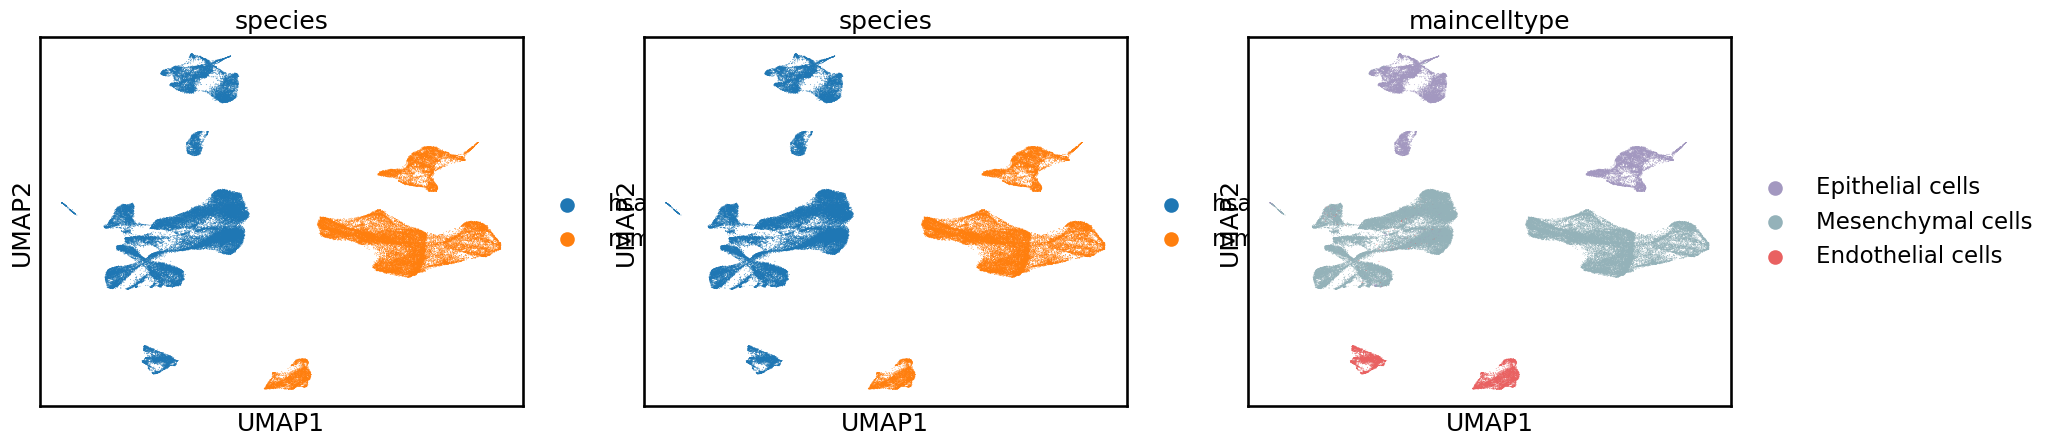

Start computing various batch metrics using scIB.
PC regression


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Silhouette batch
Graph connectivity


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/

kBET
batch: species
0 labels consist of a single batch or is too small. Skip.
Use 70 nearest neighbors.
importing expression matrix
kBET estimation
Number of kBET tests is set to 696.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Use 70 nearest neighbors.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9
Adding diffusion to step 10


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


importing expression matrix
kBET estimation
Number of kBET tests is set to 1819.
Use 70 nearest neighbors.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


importing expression matrix
kBET estimation
Number of kBET tests is set to 6520.
batch: species
0 labels consist of a single batch or is too small. Skip.
Use 70 nearest neighbors.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9
importing expression matrix
kBET estimation
Number of kBET tests is set to 1819.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Use 70 nearest neighbors.
Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9
Adding diffusion to step 10
Adding diffusion to step 11


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


importing expression matrix
kBET estimation
Number of kBET tests is set to 6520.
Use 70 nearest neighbors.
Adding diffusion to step 4
importing expression matrix
kBET estimation
Number of kBET tests is set to 696.


/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/kbet.py:229: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


NMI
clustering optimization with leiden
Cluster for cluster_0.2 with leiden
resolution: 0.2, nmi: 0.5325696852851589
Cluster for cluster_0.4 with leiden
resolution: 0.4, nmi: 0.42589001551025074
Cluster for cluster_0.6 with leiden
resolution: 0.6, nmi: 0.3928109525669913
Cluster for cluster_0.8 with leiden
resolution: 0.8, nmi: 0.37475713776544345
Cluster for cluster_1.0 with leiden
resolution: 1.0, nmi: 0.35356652252166193
Cluster for cluster_1.2 with leiden
resolution: 1.2, nmi: 0.34371366233559497
Cluster for cluster_1.4 with leiden
resolution: 1.4, nmi: 0.331064822330591
Cluster for cluster_1.6 with leiden
resolution: 1.6, nmi: 0.3246829124716315
Cluster for cluster_1.8 with leiden
resolution: 1.8, nmi: 0.32077577939894747
Cluster for cluster_2.0 with leiden
resolution: 2.0, nmi: 0.31257367222760424
optimised clustering against maincelltype
optimal cluster resolution: 0.2
optimal score: 0.5325696852851589
Recompute neighbors on rep X_pca instead of None
Cluster for cluster_0.2 with

/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/isolated_labels.py:186: UserWarning: iso_threshold is equal to number of batches in data, no isolated labels will be found
  isolated_labels = get_isolated_labels(
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/isolated_labels.py:212: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series(scores)
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/isolated_labels.py:186: UserWarning: iso_threshold is equal to number of batches in data, no isolated labels will be found
  isolated_labels = get_isolated_labels(
/share/home/lhlin/.conda/envs/scib/lib/python3.11/site-packages/scib/metrics/isolated_labels.py:212: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype e

In [11]:
res = run_scIB_metrics(input_h5ad=input_h5ad,
                       unintegrated_h5ad=unintegrated_h5ad,
                       out_integrated_metrics=out_integrated_metrics,
                       out_integrated_basw=out_integrated_basw,
                       out_orig_metrics=out_orig_metrics,
                       out_orig_basw=out_orig_basw,
                       out_h5ad=out_h5ad,
                       species_key=species_key,
                       batch_key=batch_key,
                       cluster_key=cluster_key,
                       integration_method=integration_method)

In [12]:
adata

NameError: name 'adata' is not defined